# [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer)

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Let's see if we can create a classifier that scores at least a 99% accuracy. For this task, we'll use the fastai MNIST dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from sklearn.model_selection import train_test_split

In [3]:
path = Path('./data/')
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
path.ls(), df.shape, test_df.shape

([PosixPath('data/submission.csv'),
  PosixPath('data/test.csv'),
  PosixPath('data/train.csv'),
  PosixPath('data/sample_submission.csv')],
 (42000, 785),
 (28000, 784))

## Put data into a databunch

### Grab images & labels

In [4]:
labels = df['label'].values
images = df[[c for c in df.columns if c != 'label']]
images = images.values.reshape(-1, 1, 28, 28)
images = np.repeat(images, 3, axis=1)

test_images = test_df.values.reshape(-1, 1, 28, 28)
test_images = np.repeat(test_images, 3, axis=1)

labels.shape, images.shape, test_images.shape

((42000,), (42000, 3, 28, 28), (28000, 3, 28, 28))

### Normalize images

In [5]:
images_mean = images.mean()
images_std = images.std()

def normalize(imgs): return (imgs - images_mean) / images_std

images = normalize(images)
test_images = normalize(test_images)

labels.shape, images.shape, test_images.shape, images.mean(), images.std(), test_images.mean(), test_images.std()

((42000,),
 (42000, 3, 28, 28),
 (28000, 3, 28, 28),
 2.1102797010471455e-17,
 0.9999999999999981,
 -0.0007291270898605288,
 0.9992572115903917)

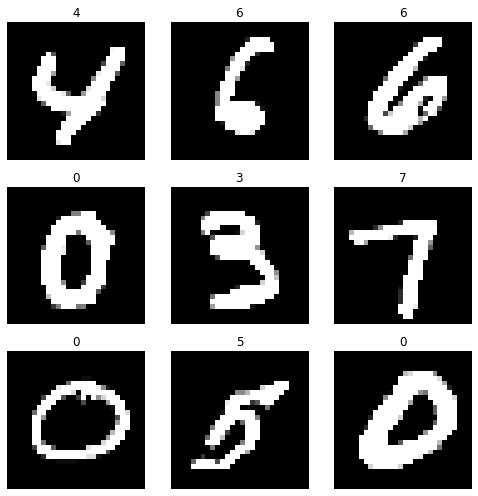

In [6]:
class ArrayImageList(ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)),inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],label_cls=label_cls,**kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = torch.tensor(n).float()
        return Image(n)

data = (ArrayImageList.from_numpy(images)
        .split_subsets(train_size=0.8, valid_size=0.2)
        .label_from_array(np.int_(labels))
        .add_test(ArrayImageList.from_numpy(test_images))
        .databunch(bs=512))

data.show_batch(rows=3, figsize=(7,7))

In [7]:
# def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
#     "Computes accuracy with `targs` when `input` is bs * n_classes."
#     n = targs.shape[0]
#     input = input.argmax(dim=-1).view(n,-1)
#     targs = targs.view(n,-1).long()
#     return (input==targs).float().mean()

def conv_layer(n_in, n_out, kernel):
    return nn.Sequential(
        nn.Conv2d(n_in, n_out, kernel, stride=2, padding=2),
        nn.ReLU(),
    )

model = nn.Sequential(
    conv_layer(3, 8, 5),
    conv_layer(8, 16, 3),
    conv_layer(16, 32, 3),
    conv_layer(32, 32, 3),
    Lambda(lambda x: torch.flatten(x)),
    nn.Linear(512, 10),
)

learner = cnn_learner(data, models.resnet50, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


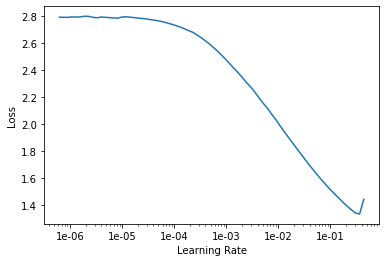

In [8]:
learner.lr_find()
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.595170,0.167872,0.948214,00:13
1,0.196381,0.072385,0.977738,00:11
2,0.085743,0.071943,0.979881,00:11
3,0.041340,0.039946,0.987738,00:11
4,0.018299,0.039000,0.988095,00:11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


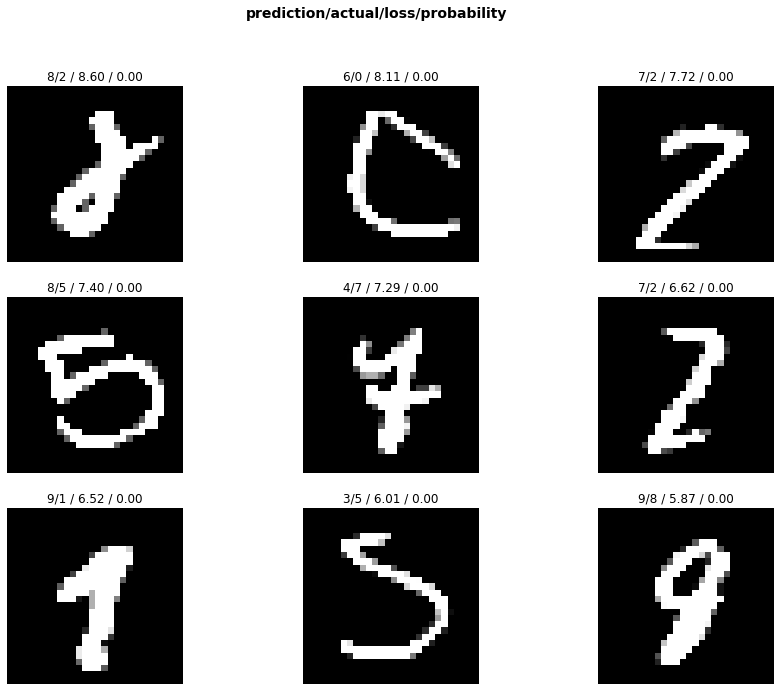

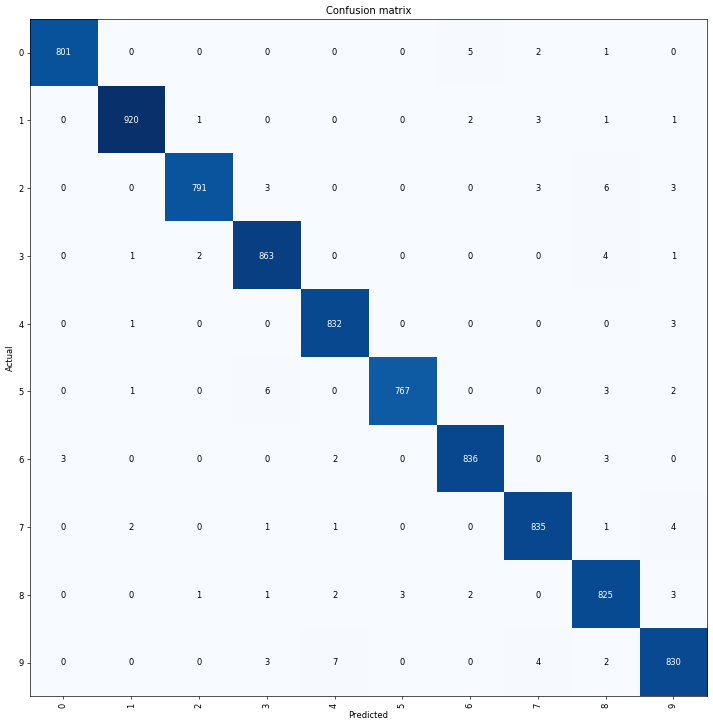

In [18]:
def interp_learner(learner):
    interp = ClassificationInterpretation.from_learner(learner)
    losses,idxs = interp.top_losses()
    interp.plot_top_losses(9, figsize=(15,11))
    interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
    interp.most_confused(min_val=2)

interp_learner(learner)

## Unfreeze and train all layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


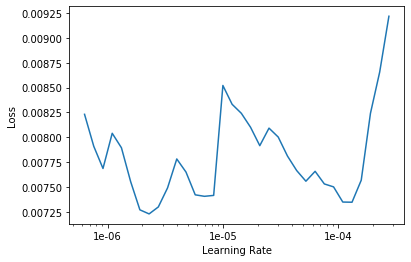

In [19]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.save('resnet50-stage-1')

In [21]:
learner.fit_one_cycle(5, slice(5e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.009785,0.048338,0.986786,00:14
1,0.020279,0.044739,0.988095,00:14
2,0.013217,0.037108,0.989881,00:14
3,0.006043,0.032656,0.991310,00:14
4,0.002527,0.032954,0.991905,00:14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


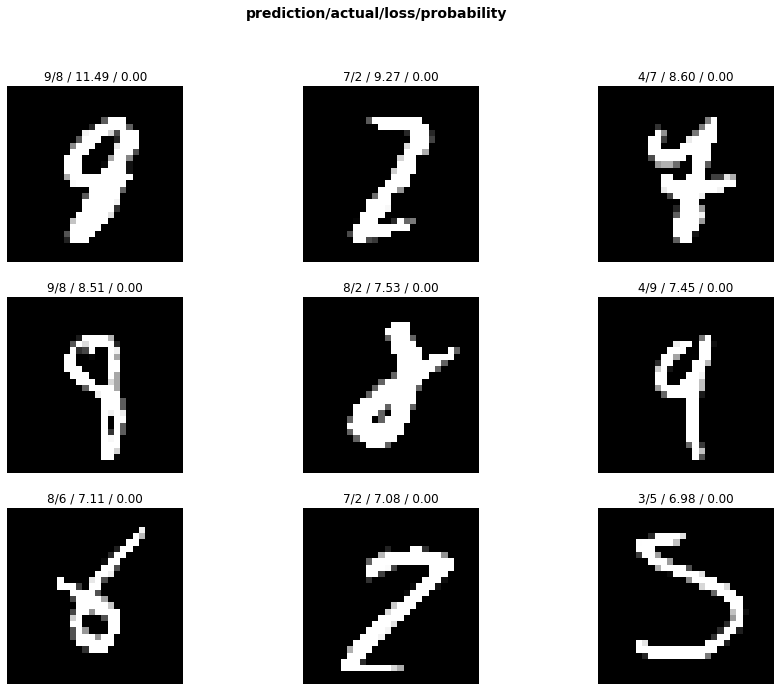

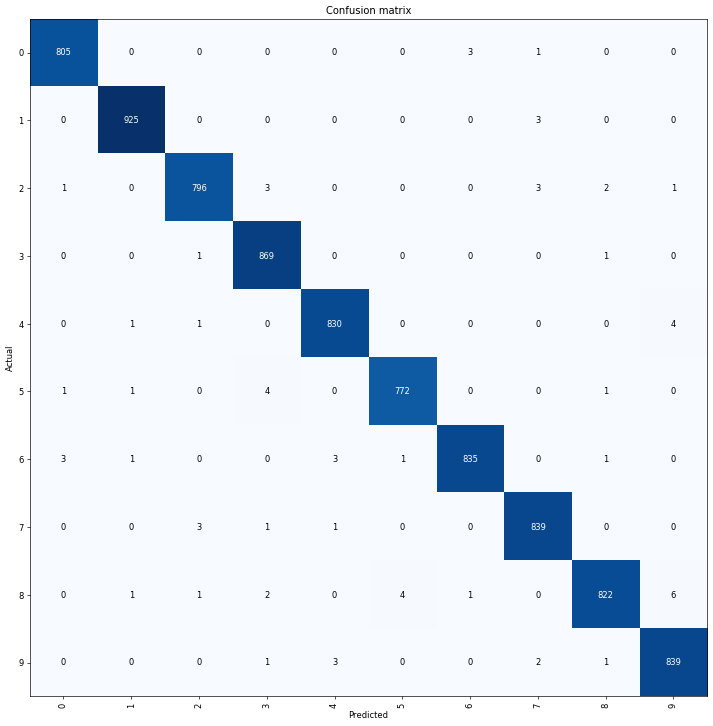

In [22]:
interp_learner(learner)

In [23]:
learner.save('resnet50-stage-2')

## Create Predictions

In [24]:
preds = learner.get_preds(ds_type=DatasetType.Test)
preds

[tensor([[1.2742e-08, 6.2046e-08, 1.0000e+00,  ..., 2.0580e-07, 1.2369e-07,
          1.7553e-08],
         [9.9997e-01, 2.8852e-06, 7.1135e-06,  ..., 7.3980e-07, 7.6853e-06,
          2.9235e-06],
         [1.3982e-06, 1.6927e-08, 6.0685e-06,  ..., 8.4366e-07, 5.6729e-06,
          9.9995e-01],
         ...,
         [1.1937e-07, 1.0625e-07, 2.6296e-07,  ..., 6.0695e-08, 5.7772e-07,
          3.1504e-08],
         [2.7919e-07, 3.0160e-09, 7.9836e-08,  ..., 2.4696e-07, 6.2230e-07,
          9.9999e-01],
         [3.1265e-09, 2.9928e-09, 1.0000e+00,  ..., 1.8502e-08, 4.2613e-08,
          2.3306e-09]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [25]:
final_preds = [np.argmax(p).item() for p in preds[0]]
final_preds[:5], np.unique(final_preds)

([2, 0, 9, 0, 3], array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [26]:
sub = pd.DataFrame({'ImageId': range(1, len(final_preds)+1), 'Label': final_preds})
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [27]:
sub.to_csv(path/'submission.csv', index=False)